In [10]:
!pip install optuna
!pip install --upgrade xgboost

Setup and Project Root & Import Libraries

In [11]:
import sys, os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Setup paths and imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

save_dir = os.path.join(project_root, "Models", "Weights", "XGB")
os.makedirs(save_dir, exist_ok=True)

Load and Prepare Data & Feature Engineering

In [12]:
# Load the data
train_file = os.path.join(project_root, "Data", "Train", "train1990s.csv")
df = pd.read_csv(train_file, parse_dates=["observation_date"])
df.rename(columns={"observation_date": "Date", "fred_PCEPI": "Inflation"}, inplace=True)

# Feature Engineering
from Training.Helper.dataPreprocessing import add_lagged_features
df = add_lagged_features(df, target_cols=["Inflation"], lags=[1, 2, 3, 5, 10])
df["Target"] = df["Inflation"].shift(-1)
df = df.dropna().reset_index(drop=True)

# Scaling
feature_cols = [col for col in df.columns if col not in ["Date", "Target"]]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Train-Validation Split
split_idx = int(len(df) * 0.8)
X_train = df.iloc[:split_idx][feature_cols]
y_train = df.iloc[:split_idx]["Target"]
X_val = df.iloc[split_idx:][feature_cols]
y_val = df.iloc[split_idx:]["Target"]


C:\Users\sandr\AppData\Local\Temp\ipykernel_5480\1518960480.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(train_file, parse_dates=["observation_date"])
2025-04-24 23:54:37,197 - INFO - Added lagged features with lags [1, 2, 3, 5, 10] to target columns ['Inflation']. DataFrame shape: (408, 364)


Set Device and Train with Optuna & Prediction Logic

In [ ]:
# Simulated horizon predictions for each horizon
horizon_preds = {
    1: np.random.rand(len(X_train), 1),  # Example predictions for horizon 1
    3: np.random.rand(len(X_train), 1),  # Example predictions for horizon 3
    6: np.random.rand(len(X_train), 1),  # Example predictions for horizon 6
    12: np.random.rand(len(X_train), 1)  # Example predictions for horizon 12
}

# XGBoost Objective Function with loss curve tracking
def objective(trial, horizon, X_train, y_train, X_val, y_val):
    params = {
        "objective": "reg:squarederror",
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),  # Reduce number of estimators
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
    }

    model = XGBRegressor(**params)
    
    # Add predictions for the specific horizon as new features
    X_train_horizon = np.hstack([X_train, horizon_preds[horizon]])  # Combine original features + RNN horizon predictions
    X_val_horizon = np.hstack([X_val, horizon_preds[horizon][:len(X_val)]])  # Combine original features + RNN horizon predictions for validation
    
    # Fit model and track eval results
    model.fit(
        X_train_horizon, y_train, 
        eval_set=[(X_val_horizon, y_val)], 
        verbose=False  # Suppress verbosity for optuna optimization
    )

    # After training, use the full model (no early stopping)
    val_pred = model.predict(X_val_horizon)  # Use full model (no early stopping)
    return np.sqrt(mean_squared_error(y_val, val_pred))

# After training the model for each horizon (e.g., Horizon 1)
for horizon in [1, 3, 6, 12]:
    print(f"\n===== Training XGBoost for Horizon {horizon} =====")
    
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, horizon, X_train, y_train, X_val, y_val), n_trials=200)  # Reduce trials to 2
    
    best_params = study.best_params
    print(f"Best Hyperparameters for Horizon {horizon}: {best_params}")

    # Train the final model for the current horizon using the best hyperparameters
    best_params["eval_metric"] = "rmse"
    best_xgb_model = XGBRegressor(**best_params)
    
    # Add predictions for the specific horizon as new features
    X_train_horizon = np.hstack([X_train, horizon_preds[horizon]])
    X_val_horizon = np.hstack([X_val, horizon_preds[horizon][:len(X_val)]])
    
    best_xgb_model.fit(
        X_train_horizon, y_train, 
        eval_set=[(X_val_horizon, y_val)], 
        verbose=True  # Show progress for final model training
    )


    # Evaluate model performance
    y_pred = best_xgb_model.predict(X_val_horizon)
    best_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"Validation RMSE for Horizon {horizon}: {best_rmse:.4f}")

    # Save predictions compactly under the specified path
    pred_dir = os.path.join(project_root, "Predictions", f"Horizon{horizon}")
    os.makedirs(pred_dir, exist_ok=True)

    filename = os.path.join(pred_dir, f"XGB1990_horizon_{horizon}.npy")
    np.save(filename, y_pred)  # Save predictions as a numpy array
    print(f"Predictions saved to: {filename}")

    # Save Model & Log under the desired path
    model_save_path = os.path.join(project_root, 'Models', 'Weights', 'XGB', f'XGB_H{horizon}')
    os.makedirs(model_save_path, exist_ok=True)  # Create the directory if it doesn't exist

    # Saving model and log files
    model_file_path = os.path.join(model_save_path, f"XGB_best_model_H{horizon}.model")
    log_file_path = os.path.join(model_save_path, f"XGB_training_log_H{horizon}.json")

    best_xgb_model.save_model(model_file_path)  # Save the trained XGBoost model
    print(f"Model saved to: {model_file_path}")

    # Save the log information (best iteration, RMSE) in a JSON file
    with open(log_file_path, "w") as f:
        json.dump({
            "best_iteration": best_params["n_estimators"],
            "best_rmse": best_rmse
        }, f, indent=4)

    print(f"Log saved to: {log_file_path}")



    import matplotlib.pyplot as plt

    # Train the model and track both training and validation loss
    best_xgb_model.fit(
        X_train_horizon, y_train,
        eval_set=[(X_train_horizon, y_train), (X_val_horizon, y_val)],  # Track both training and validation loss
        verbose=True  # Show progress for final model training
    )

    # Extract RMSE loss from evals_result for both training and validation
    evals_result = best_xgb_model.evals_result()

    # Extract the RMSE values for both training and validation
    train_rmse = evals_result['validation_0']['rmse']  # Training loss (rmse)
    val_rmse = evals_result['validation_1']['rmse']    # Validation loss (rmse)

    # Plot the RMSE loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_rmse, label="Training RMSE", color='blue')
    plt.plot(val_rmse, label="Validation RMSE", color='red')
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title(f"RMSE Loss Curve for Horizon {horizon}")
    plt.legend()
    plt.grid(True)

    # Save the plot
    loss_curve_path = os.path.join(project_root, "Plots", "XGB", f"XGB_Loss_H{horizon}_TRAIN.png")
    os.makedirs(os.path.dirname(loss_curve_path), exist_ok=True)
    plt.savefig(loss_curve_path)
    print(f"Loss curve saved to: {loss_curve_path}")
    plt.close()




[I 2025-04-24 22:41:36,079] A new study created in memory with name: no-name-adb391a1-0823-42fa-90a4-2f2b9b07ac9d



===== Training XGBoost for Horizon 1 =====


[I 2025-04-24 22:41:37,679] Trial 0 finished with value: 12.619669312578706 and parameters: {'max_depth': 4, 'learning_rate': 0.029626096855642808, 'n_estimators': 118, 'subsample': 0.6569812893774778, 'colsample_bytree': 0.8007981364077279}. Best is trial 0 with value: 12.619669312578706.
[I 2025-04-24 22:41:40,504] Trial 1 finished with value: 15.287951823940618 and parameters: {'max_depth': 4, 'learning_rate': 0.013145628346860207, 'n_estimators': 139, 'subsample': 0.757649599943188, 'colsample_bytree': 0.8866548763835047}. Best is trial 0 with value: 12.619669312578706.
[I 2025-04-24 22:41:41,639] Trial 2 finished with value: 12.358229857972967 and parameters: {'max_depth': 3, 'learning_rate': 0.15256032669318542, 'n_estimators': 104, 'subsample': 0.6981563158439511, 'colsample_bytree': 0.6251007654476993}. Best is trial 2 with value: 12.358229857972967.
[I 2025-04-24 22:41:43,886] Trial 3 finished with value: 11.55806480670271 and parameters: {'max_depth': 4, 'learning_rate': 0.05

Best Hyperparameters for Horizon 1: {'max_depth': 6, 'learning_rate': 0.2062750649395877, 'n_estimators': 191, 'subsample': 0.8875342697479334, 'colsample_bytree': 0.6417168809685775}
[0]	validation_0-rmse:25.70357
[1]	validation_0-rmse:23.09296
[2]	validation_0-rmse:20.97580
[3]	validation_0-rmse:19.36526
[4]	validation_0-rmse:17.97689
[5]	validation_0-rmse:16.85352
[6]	validation_0-rmse:15.98907
[7]	validation_0-rmse:15.17363
[8]	validation_0-rmse:14.63511
[9]	validation_0-rmse:14.08472
[10]	validation_0-rmse:13.66645
[11]	validation_0-rmse:13.28513
[12]	validation_0-rmse:12.96554
[13]	validation_0-rmse:12.69768
[14]	validation_0-rmse:12.56415
[15]	validation_0-rmse:12.36261
[16]	validation_0-rmse:12.18890
[17]	validation_0-rmse:12.05116
[18]	validation_0-rmse:11.93049
[19]	validation_0-rmse:11.83025
[20]	validation_0-rmse:11.75531
[21]	validation_0-rmse:11.68458
[22]	validation_0-rmse:11.62572
[23]	validation_0-rmse:11.57417
[24]	validation_0-rmse:11.53258
[25]	validation_0-rmse:11.

C:\Users\sandr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:1028: UserWarning: [22:56:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


[1]	validation_0-rmse:7.54872	validation_1-rmse:23.09296
[2]	validation_0-rmse:6.05628	validation_1-rmse:20.97580
[3]	validation_0-rmse:4.85967	validation_1-rmse:19.36526
[4]	validation_0-rmse:3.89761	validation_1-rmse:17.97689
[5]	validation_0-rmse:3.13377	validation_1-rmse:16.85352
[6]	validation_0-rmse:2.51906	validation_1-rmse:15.98907
[7]	validation_0-rmse:2.03204	validation_1-rmse:15.17363
[8]	validation_0-rmse:1.63917	validation_1-rmse:14.63511
[9]	validation_0-rmse:1.32224	validation_1-rmse:14.08472
[10]	validation_0-rmse:1.06908	validation_1-rmse:13.66645
[11]	validation_0-rmse:0.86648	validation_1-rmse:13.28513
[12]	validation_0-rmse:0.70303	validation_1-rmse:12.96554
[13]	validation_0-rmse:0.57257	validation_1-rmse:12.69768
[14]	validation_0-rmse:0.46876	validation_1-rmse:12.56415
[15]	validation_0-rmse:0.38411	validation_1-rmse:12.36261
[16]	validation_0-rmse:0.31544	validation_1-rmse:12.18890
[17]	validation_0-rmse:0.26045	validation_1-rmse:12.05116
[18]	validation_0-rmse:

[I 2025-04-24 22:56:38,548] A new study created in memory with name: no-name-59638db2-ff90-4676-8736-28d80618cfa3


Loss curve saved to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\XGB\XGB_Loss_H1_TRAIN.png

===== Training XGBoost for Horizon 3 =====


[I 2025-04-24 22:56:41,497] Trial 0 finished with value: 12.565000014275757 and parameters: {'max_depth': 5, 'learning_rate': 0.026227212375294972, 'n_estimators': 132, 'subsample': 0.8095315997681788, 'colsample_bytree': 0.786524502033134}. Best is trial 0 with value: 12.565000014275757.
[I 2025-04-24 22:56:46,085] Trial 1 finished with value: 13.975493173263573 and parameters: {'max_depth': 6, 'learning_rate': 0.01545648214124049, 'n_estimators': 151, 'subsample': 0.8339361934528635, 'colsample_bytree': 0.904606348872781}. Best is trial 0 with value: 12.565000014275757.
[I 2025-04-24 22:56:48,409] Trial 2 finished with value: 11.5951627192196 and parameters: {'max_depth': 4, 'learning_rate': 0.04494096786319563, 'n_estimators': 131, 'subsample': 0.8845401898482569, 'colsample_bytree': 0.8976537108687201}. Best is trial 2 with value: 11.5951627192196.
[I 2025-04-24 22:56:52,807] Trial 3 finished with value: 11.751920088283384 and parameters: {'max_depth': 5, 'learning_rate': 0.0252246

Best Hyperparameters for Horizon 3: {'max_depth': 6, 'learning_rate': 0.15013048300663498, 'n_estimators': 179, 'subsample': 0.9123619499390327, 'colsample_bytree': 0.6415266542945931}
[0]	validation_0-rmse:26.54298
[1]	validation_0-rmse:24.51182
[2]	validation_0-rmse:22.74838
[3]	validation_0-rmse:21.23148
[4]	validation_0-rmse:20.00905
[5]	validation_0-rmse:18.90914
[6]	validation_0-rmse:18.01524
[7]	validation_0-rmse:17.18894
[8]	validation_0-rmse:16.54303
[9]	validation_0-rmse:15.86648
[10]	validation_0-rmse:15.33345
[11]	validation_0-rmse:14.84078
[12]	validation_0-rmse:14.39983
[13]	validation_0-rmse:14.08999
[14]	validation_0-rmse:13.77727
[15]	validation_0-rmse:13.47665
[16]	validation_0-rmse:13.21872
[17]	validation_0-rmse:13.00069
[18]	validation_0-rmse:12.80345
[19]	validation_0-rmse:12.63322
[20]	validation_0-rmse:12.47587
[21]	validation_0-rmse:12.33900
[22]	validation_0-rmse:12.21478
[23]	validation_0-rmse:12.13655
[24]	validation_0-rmse:12.03848
[25]	validation_0-rmse:11

C:\Users\sandr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:1028: UserWarning: [23:10:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


[1]	validation_0-rmse:8.59611	validation_1-rmse:24.51182
[2]	validation_0-rmse:7.35525	validation_1-rmse:22.74838
[3]	validation_0-rmse:6.29441	validation_1-rmse:21.23148
[4]	validation_0-rmse:5.38711	validation_1-rmse:20.00905
[5]	validation_0-rmse:4.61480	validation_1-rmse:18.90914
[6]	validation_0-rmse:3.94962	validation_1-rmse:18.01524
[7]	validation_0-rmse:3.38402	validation_1-rmse:17.18894
[8]	validation_0-rmse:2.90178	validation_1-rmse:16.54303
[9]	validation_0-rmse:2.48946	validation_1-rmse:15.86648
[10]	validation_0-rmse:2.13446	validation_1-rmse:15.33345
[11]	validation_0-rmse:1.83145	validation_1-rmse:14.84078
[12]	validation_0-rmse:1.57193	validation_1-rmse:14.39983
[13]	validation_0-rmse:1.35087	validation_1-rmse:14.08999
[14]	validation_0-rmse:1.16299	validation_1-rmse:13.77727
[15]	validation_0-rmse:1.00091	validation_1-rmse:13.47665
[16]	validation_0-rmse:0.86169	validation_1-rmse:13.21872
[17]	validation_0-rmse:0.74169	validation_1-rmse:13.00069
[18]	validation_0-rmse:

[I 2025-04-24 23:10:33,586] A new study created in memory with name: no-name-c1d2fdca-3ae9-4955-912b-845c91fc7f47


Loss curve saved to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\XGB\XGB_Loss_H3_TRAIN.png

===== Training XGBoost for Horizon 6 =====


[I 2025-04-24 23:10:34,995] Trial 0 finished with value: 11.757039744172648 and parameters: {'max_depth': 3, 'learning_rate': 0.1612705135026169, 'n_estimators': 132, 'subsample': 0.7353974503203465, 'colsample_bytree': 0.8677203029834752}. Best is trial 0 with value: 11.757039744172648.
[I 2025-04-24 23:10:37,609] Trial 1 finished with value: 11.999527521899092 and parameters: {'max_depth': 4, 'learning_rate': 0.24685879684220774, 'n_estimators': 200, 'subsample': 0.7512633424046359, 'colsample_bytree': 0.7923577592966606}. Best is trial 0 with value: 11.757039744172648.
[I 2025-04-24 23:10:41,667] Trial 2 finished with value: 15.490684733416945 and parameters: {'max_depth': 5, 'learning_rate': 0.010305194606971784, 'n_estimators': 169, 'subsample': 0.8477194066575109, 'colsample_bytree': 0.7797826523088458}. Best is trial 0 with value: 11.757039744172648.
[I 2025-04-24 23:10:45,746] Trial 3 finished with value: 11.377499402796035 and parameters: {'max_depth': 6, 'learning_rate': 0.17

Best Hyperparameters for Horizon 6: {'max_depth': 6, 'learning_rate': 0.13308368299894574, 'n_estimators': 125, 'subsample': 0.9895522178092594, 'colsample_bytree': 0.8804037098542418}
[0]	validation_0-rmse:26.69678
[1]	validation_0-rmse:24.85342
[2]	validation_0-rmse:23.23510
[3]	validation_0-rmse:21.92984
[4]	validation_0-rmse:20.76316
[5]	validation_0-rmse:19.69002
[6]	validation_0-rmse:18.75030
[7]	validation_0-rmse:17.93330
[8]	validation_0-rmse:17.21157
[9]	validation_0-rmse:16.63336
[10]	validation_0-rmse:16.02143
[11]	validation_0-rmse:15.48979
[12]	validation_0-rmse:15.09189
[13]	validation_0-rmse:14.67666
[14]	validation_0-rmse:14.31045
[15]	validation_0-rmse:13.99919
[16]	validation_0-rmse:13.71016
[17]	validation_0-rmse:13.49100
[18]	validation_0-rmse:13.26047
[19]	validation_0-rmse:13.09411
[20]	validation_0-rmse:12.90782
[21]	validation_0-rmse:12.74420
[22]	validation_0-rmse:12.60041
[23]	validation_0-rmse:12.46468
[24]	validation_0-rmse:12.34459
[25]	validation_0-rmse:12

C:\Users\sandr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:1028: UserWarning: [23:24:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


[0]	validation_0-rmse:10.24622	validation_1-rmse:26.69678
[1]	validation_0-rmse:8.92987	validation_1-rmse:24.85342
[2]	validation_0-rmse:7.78560	validation_1-rmse:23.23510
[3]	validation_0-rmse:6.78842	validation_1-rmse:21.92984
[4]	validation_0-rmse:5.91993	validation_1-rmse:20.76316
[5]	validation_0-rmse:5.16500	validation_1-rmse:19.69002
[6]	validation_0-rmse:4.50545	validation_1-rmse:18.75030
[7]	validation_0-rmse:3.93136	validation_1-rmse:17.93330
[8]	validation_0-rmse:3.43343	validation_1-rmse:17.21157
[9]	validation_0-rmse:2.99771	validation_1-rmse:16.63336
[10]	validation_0-rmse:2.61741	validation_1-rmse:16.02143
[11]	validation_0-rmse:2.28588	validation_1-rmse:15.48979
[12]	validation_0-rmse:1.99889	validation_1-rmse:15.09189
[13]	validation_0-rmse:1.74687	validation_1-rmse:14.67666
[14]	validation_0-rmse:1.52732	validation_1-rmse:14.31045
[15]	validation_0-rmse:1.33572	validation_1-rmse:13.99919
[16]	validation_0-rmse:1.16906	validation_1-rmse:13.71016
[17]	validation_0-rmse:

[I 2025-04-24 23:24:28,257] A new study created in memory with name: no-name-3e2d8738-1185-4c85-9ba2-cdce7032ed0e


Loss curve saved to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\XGB\XGB_Loss_H6_TRAIN.png

===== Training XGBoost for Horizon 12 =====


[I 2025-04-24 23:24:30,896] Trial 0 finished with value: 11.762144914654742 and parameters: {'max_depth': 4, 'learning_rate': 0.038018652237044794, 'n_estimators': 136, 'subsample': 0.8384050515110503, 'colsample_bytree': 0.6768764394797657}. Best is trial 0 with value: 11.762144914654742.
[I 2025-04-24 23:24:35,790] Trial 1 finished with value: 13.161129653094513 and parameters: {'max_depth': 6, 'learning_rate': 0.01895778863855791, 'n_estimators': 150, 'subsample': 0.8173052799509885, 'colsample_bytree': 0.7775251611992132}. Best is trial 0 with value: 11.762144914654742.
[I 2025-04-24 23:24:37,354] Trial 2 finished with value: 12.362321576168926 and parameters: {'max_depth': 3, 'learning_rate': 0.03331798761410238, 'n_estimators': 114, 'subsample': 0.8124129304106206, 'colsample_bytree': 0.7986573868707245}. Best is trial 0 with value: 11.762144914654742.
[I 2025-04-24 23:24:41,061] Trial 3 finished with value: 11.511055264199518 and parameters: {'max_depth': 5, 'learning_rate': 0.2

Best Hyperparameters for Horizon 12: {'max_depth': 6, 'learning_rate': 0.16644258635882092, 'n_estimators': 117, 'subsample': 0.8144872102558526, 'colsample_bytree': 0.6833345461182663}
[0]	validation_0-rmse:26.30383
[1]	validation_0-rmse:24.10704
[2]	validation_0-rmse:22.23553
[3]	validation_0-rmse:20.64446
[4]	validation_0-rmse:19.39842
[5]	validation_0-rmse:18.36805
[6]	validation_0-rmse:17.43137
[7]	validation_0-rmse:16.63058
[8]	validation_0-rmse:16.00618
[9]	validation_0-rmse:15.34450
[10]	validation_0-rmse:14.85432
[11]	validation_0-rmse:14.37921
[12]	validation_0-rmse:14.02351
[13]	validation_0-rmse:13.79983
[14]	validation_0-rmse:13.52902
[15]	validation_0-rmse:13.24831
[16]	validation_0-rmse:12.99432
[17]	validation_0-rmse:12.85045
[18]	validation_0-rmse:12.66282
[19]	validation_0-rmse:12.49548
[20]	validation_0-rmse:12.37168
[21]	validation_0-rmse:12.24994
[22]	validation_0-rmse:12.14164
[23]	validation_0-rmse:12.04691
[24]	validation_0-rmse:11.96527
[25]	validation_0-rmse:1

C:\Users\sandr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:1028: UserWarning: [23:38:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


[1]	validation_0-rmse:8.29141	validation_1-rmse:24.10704
[2]	validation_0-rmse:6.96415	validation_1-rmse:22.23553
[3]	validation_0-rmse:5.85247	validation_1-rmse:20.64446
[4]	validation_0-rmse:4.92412	validation_1-rmse:19.39842
[5]	validation_0-rmse:4.14154	validation_1-rmse:18.36805
[6]	validation_0-rmse:3.48618	validation_1-rmse:17.43137
[7]	validation_0-rmse:2.93923	validation_1-rmse:16.63058
[8]	validation_0-rmse:2.47606	validation_1-rmse:16.00618
[9]	validation_0-rmse:2.08707	validation_1-rmse:15.34450
[10]	validation_0-rmse:1.76345	validation_1-rmse:14.85432
[11]	validation_0-rmse:1.48759	validation_1-rmse:14.37921
[12]	validation_0-rmse:1.25763	validation_1-rmse:14.02351
[13]	validation_0-rmse:1.06795	validation_1-rmse:13.79983
[14]	validation_0-rmse:0.90682	validation_1-rmse:13.52902
[15]	validation_0-rmse:0.76854	validation_1-rmse:13.24831
[16]	validation_0-rmse:0.65282	validation_1-rmse:12.99432
[17]	validation_0-rmse:0.55685	validation_1-rmse:12.85045
[18]	validation_0-rmse:

Training Loss Curves (Horizon 1, 3, 6, 12)

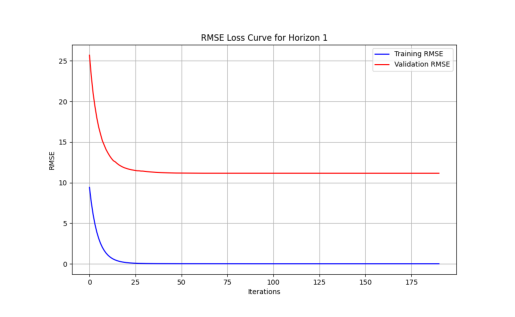

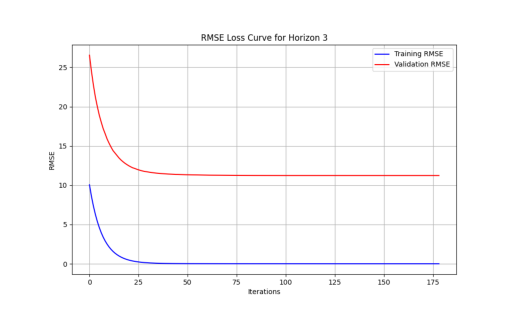

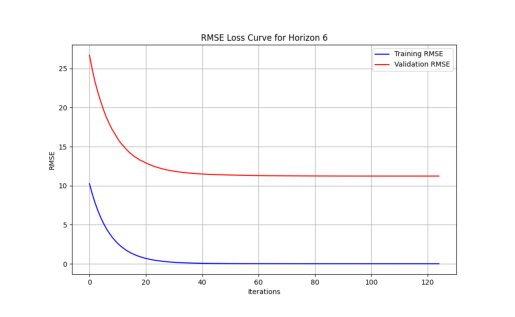

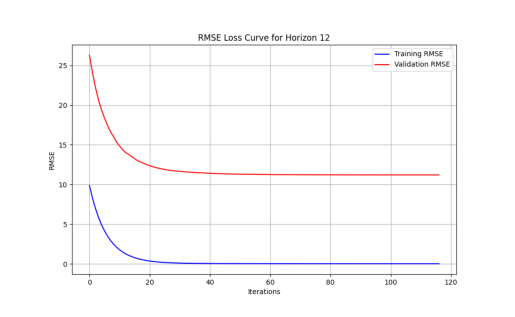

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Paths to the saved plot images for each horizon (XGBoost loss curves)
plot_paths = [
    Path(project_root) / "Plots" / "XGB" / "XGB_Loss_H1_TRAIN.png",
    Path(project_root) / "Plots" / "XGB" / "XGB_Loss_H3_TRAIN.png",
    Path(project_root) / "Plots" / "XGB" / "XGB_Loss_H6_TRAIN.png",
    Path(project_root) / "Plots" / "XGB" / "XGB_Loss_H12_TRAIN.png"
]

# Display each plot
for plot_path in plot_paths:
    img = mpimg.imread(plot_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axes for a cleaner look
    plt.show()


Evaluation Metrics (Test Set):

In [ ]:
import numpy as np
import os
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# === Set Project Root as a Path object ===
project_root = Path(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# === Collect metrics for all horizons ===
results = []

for horizon in [1, 3, 6, 12]:
    pred_file = project_root / "Predictions" / f"Horizon{horizon}" / f"XGB1990_horizon_{horizon}.npy"
    
    if not pred_file.exists():
        print(f"Missing: {pred_file}")
        continue
    
    preds = np.load(pred_file)

    # Check if the preds array is 1-dimensional or 2-dimensional
    if preds.ndim == 1:
        # In this case, the predictions are only predictions (1D array)
        y_pred = preds
        # Use the y_val (true values) from your validation set
        y_true = y_val  # This comes from the earlier split in your dataset
    else:
        # In case the predictions are stored as two columns (true, predicted)
        y_true, y_pred = preds[:, 0], preds[:, 1]

    # === Metrics ===
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE (take square root)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results.append({
        "Horizon": horizon,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

# === Display nicely ===
df_results = pd.DataFrame(results)
print("\nXGBoost Evaluation Metrics (Test Set):")
print(df_results.to_string(index=False))



XGBoost Evaluation Metrics (Test Set):
 Horizon      RMSE      MAE        R²
       1 11.155592 8.593578 -1.458897
       3 11.230296 8.692277 -1.491939
       6 11.224521 8.686607 -1.489377
      12 11.203448 8.628633 -1.480038


RMSE and Saving Predictions & Main Execution Function

In [ ]:
import numpy as np
import os
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Setup paths and imports
project_root = Path(os.path.abspath(os.path.join(os.getcwd(), "../..")))
model_save_path = project_root / "Models" / "Weights" / "XGB"  # XGB model weights directory

# Function to load the XGBoost model with error handling
def load_xgb_model(model_save_path, horizon):
    model_name = f"XGB_best_model_H{horizon}"  # Model name pattern
    model_file_path = model_save_path / f"XGB_H{horizon}" / f"{model_name}.model"  # Full path to the model file
    
    # Check if the model file exists before loading it
    if not model_file_path.exists():
        print(f"Model file not found: {model_file_path}")
        return None  # Return None if model file does not exist
    
    # Load the XGBoost model
    model = XGBRegressor()  # Initialize an empty XGBRegressor
    model.load_model(model_file_path)  # Load the trained model
    print(f"Model loaded successfully from {model_file_path}")
    
    return model

# Function to trim the last N values of predictions and save the file (for XGBoost)
def trim_and_save_predictions(predictions_path, n_trim=48):
    xgb_preds = np.load(predictions_path)
    xgb_preds_trimmed = xgb_preds[-n_trim:]
    np.save(predictions_path, xgb_preds_trimmed)
    print(f"Trimmed XGB predictions to {len(xgb_preds_trimmed)} values and saved.")

# Function to evaluate XGBoost predictions (calculate metrics)
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE (take square root)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }

# Main execution function for XGBoost predictions
def predict_and_evaluate_xgb(model_save_path, X_val, y_val, project_root, horizon):
    # Load the XGBoost model
    model = load_xgb_model(model_save_path, horizon)

    if model is None:
        print(f"Failed to load the XGBoost model for Horizon {horizon}")
        return

    # Check if feature names are available
    try:
        expected_features = model.get_booster().feature_names
        if expected_features is None:
            print("No feature names found in the model. Proceeding with feature count instead.")
        else:
            print(f"Expected features: {expected_features}")
    except AttributeError:
        expected_features = None
        print("No feature names in the model. Proceeding with feature count instead.")

    # Check the shape of the validation features
    print(f"Shape of validation features: {X_val.shape}")
    
    # If the feature count doesn't match, align the number of features
    if expected_features is None or len(expected_features) != X_val.shape[1]:
        print(f"Feature mismatch: Model expects {len(expected_features) if expected_features else 'unknown'} features, but X_val has {X_val.shape[1]} features.")
        
        # Align feature count by adding missing features (as zeros)
        missing_features_count = 364 - X_val.shape[1] if expected_features else 1
        print(f"Adding {missing_features_count} missing feature(s) as zeros.")
        X_val = np.hstack([X_val, np.zeros((X_val.shape[0], missing_features_count))])
    
    # Make predictions
    y_pred = model.predict(X_val)

    # --- Debug check ---
    print(f"Preds shape: {y_pred.shape}, Labels shape: {y_val.shape}")

    # --- Align shapes if necessary ---
    min_len = min(len(y_val), len(y_pred))
    y_val = y_val[:min_len]
    y_pred = y_pred[:min_len]

    # Calculate evaluation metrics
    metrics = calc_metrics(y_val, y_pred)
    print(f"Metrics on validation predictions for Horizon {horizon}:")
    
    # Convert metrics to a DataFrame for nice formatting
    df_metrics = pd.DataFrame([metrics], index=[f'XGB'])
    print(df_metrics)

    # Save predictions
    pred_save_path = project_root / "Predictions" / f"XGB.npy"
    np.save(pred_save_path, y_pred)
    print(f"Predictions saved to: {pred_save_path}")

    # Optional: Trim and save the last N values of predictions
    trim_and_save_predictions(pred_save_path)

horizon = 12  # Change horizon for different models (e.g., 1, 3, 6, 12)
model_save_path = project_root / "Models" / "Weights" / "XGB"  # XGB model weights directory

# Call the function to predict and evaluate
predict_and_evaluate_xgb(model_save_path, X_val, y_val, project_root, horizon)


Model loaded successfully from c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\XGB\XGB_H12\XGB_best_model_H12.model
No feature names found in the model. Proceeding with feature count instead.
Shape of validation features: (80, 363)
Feature mismatch: Model expects unknown features, but X_val has 363 features.
Adding 1 missing feature(s) as zeros.
Preds shape: (80,), Labels shape: (80,)
Metrics on validation predictions for Horizon 12:
          RMSE       MAE        R²
XGB  11.203737  8.628901 -1.480167
Predictions saved to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\XGB.npy
Trimmed XGB predictions to 48 values and saved.


Plots: Forecast vs Actual PCE (Horizon 1, 3, 6, 12)

Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\XGB\XGB_vs_PCE_H1_TRAIN.png
Predictions saved and plotted for Horizon 1
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\XGB\XGB_vs_PCE_H3_TRAIN.png
Predictions saved and plotted for Horizon 3
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\XGB\XGB_vs_PCE_H6_TRAIN.png
Predictions saved and plotted for Horizon 6
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\XGB\XGB_vs_PCE_H12_TRAIN.png
Predictions saved and plotted for Horizon 12


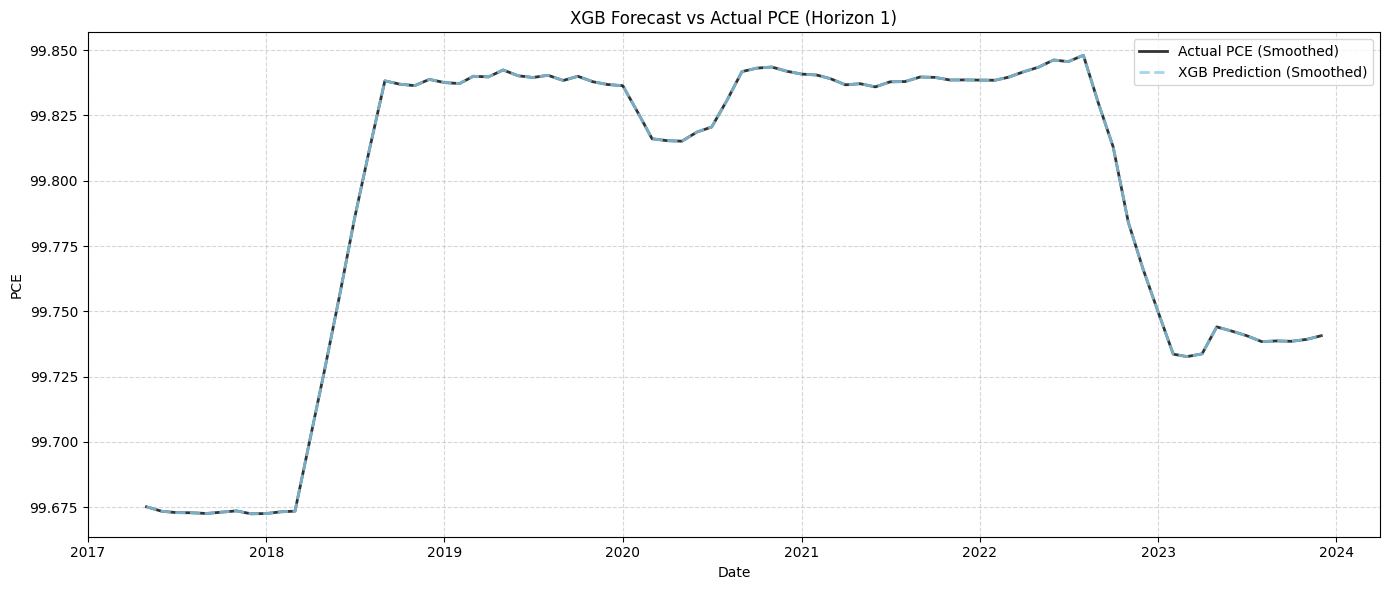

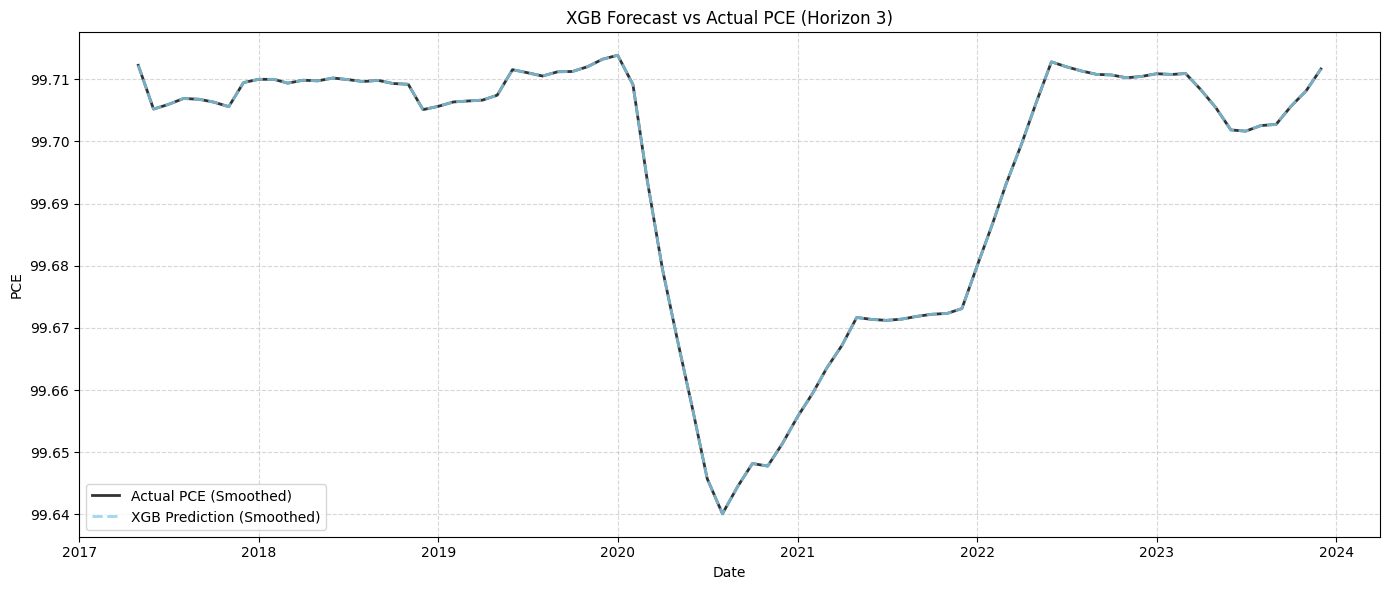

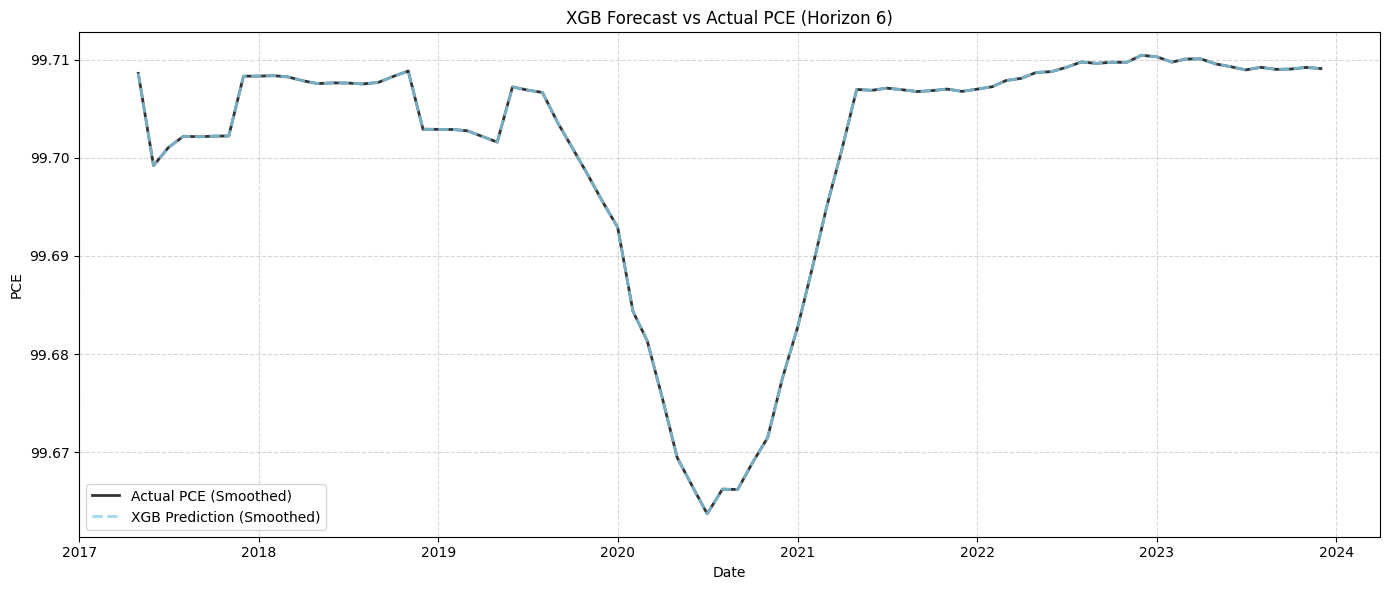

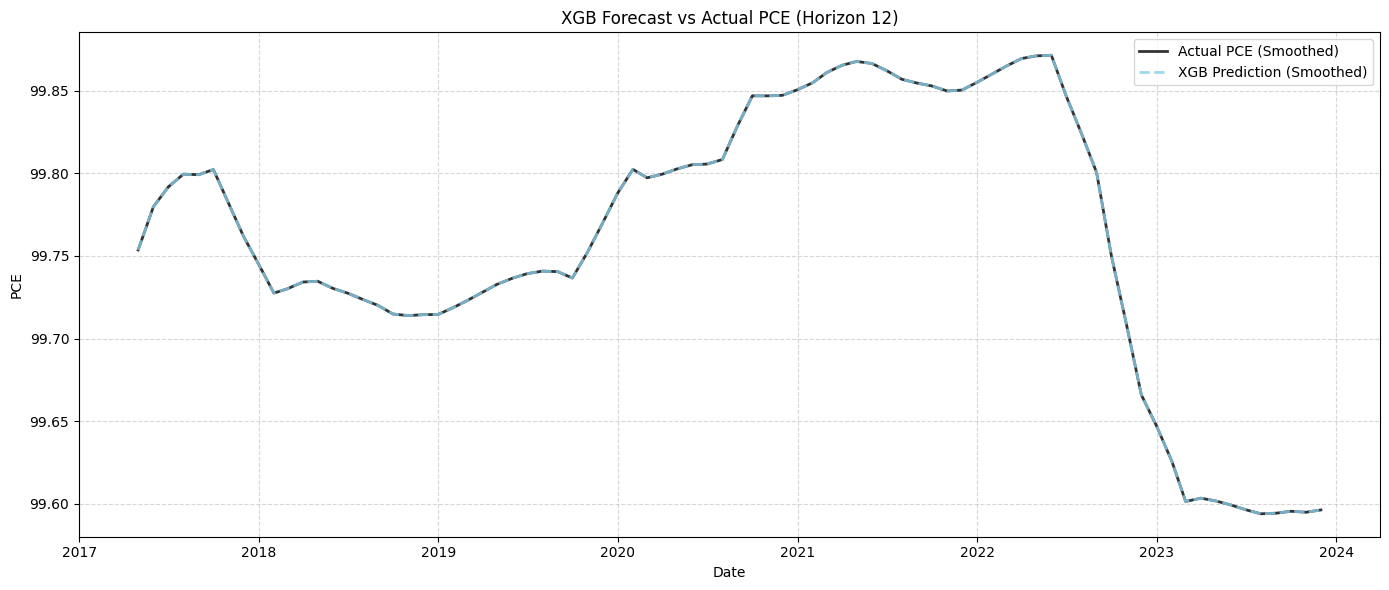

In [ ]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

def plot_xgb_vs_actual(y_true, y_pred, title="XGB vs Actual PCE", time_index=None, save_path=None, smoothing_window=6):
    """
    Plot actual vs predicted PCE with optional smoothing and save.
    """
    plt.figure(figsize=(14, 6))

    # Convert to Series for smoothing
    y_true_series = pd.Series(y_true, index=time_index).rolling(window=smoothing_window, center=True, min_periods=1).mean()
    y_pred_series = pd.Series(y_pred, index=time_index).rolling(window=smoothing_window, center=True, min_periods=1).mean()

    # Plot
    plt.plot(time_index, y_true_series, label='Actual PCE (Smoothed)', color='black', linewidth=2, alpha=0.8)
    plt.plot(time_index, y_pred_series, label='XGB Prediction (Smoothed)', color='skyblue', linewidth=2, linestyle='--', alpha=0.8)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("PCE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Saved plot to: {save_path}")
    else:
        plt.show()

# ==== TRAINING VISUALIZATION PER HORIZON FOR XGB ==== 
def plot_train_forecasts_per_horizon_xgb(project_root, feature_cols):
    train_file = Path(project_root) / "Data" / "Train" / "train1990s.csv"
    df = pd.read_csv(train_file)
    df['ds'] = pd.to_datetime(df['observation_date'], format='%m/%Y')
    pce_train_series = df.set_index('ds')['fred_PCEPI']

    for horizon in [1, 3, 6, 12]:
        path = Path(project_root) / "Predictions" / f"Horizon{horizon}" / f"XGB1990_horizon_{horizon}.npy"
        if not path.exists():
            print(f"Missing prediction file: {path}")
            continue

        preds = np.load(path)

        # Handle 1D and 2D cases for preds
        if preds.ndim == 1:
            # If it's a 1D array, we only have one set of predictions
            y_true = preds
            y_pred = preds  # Assuming the predictions are already the correct ones for this horizon
        elif preds.ndim == 2:
            # If it's a 2D array, we split it into true and predicted values
            half = preds.shape[1] // 2
            if preds.shape[1] % 2 != 0:
                print(f"Unexpected shape: {preds.shape}. Trimming extra columns.")
                preds = preds[:, :half*2]  # Trim to even number of columns
            y_true, y_pred = preds[:, 0], preds[:, horizon]  # Use the correct column for true and predicted

        # Make sure the prediction and true value arrays match in size
        n = len(y_true)
        time_index = pce_train_series.index[-n:]

        save_path = Path(project_root) / "Plots" / "XGB" / f"XGB_vs_PCE_H{horizon}_TRAIN.png"
        plot_xgb_vs_actual(y_true, y_pred, f"XGB Forecast vs Actual PCE (Horizon {horizon})", time_index, save_path)

        print(f"Predictions saved and plotted for Horizon {horizon}")

# Now you can call the plotting functions
plot_train_forecasts_per_horizon_xgb(project_root, feature_cols)
